## Постановка задачи

Задача достижимости в ориентированных графах заключается в определении того, существует ли путь между двумя вершинами, возможно ограниченный определенными правилами или шаблонами. Целью данного исследовании является анализ производительности алгоритмов решения задачи достижимости между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями.

Мы исследуем следующие две задачи:

1. Достижимость между всеми парами вершин: для каждой пары вершин $(u,v)$ в графе необходимо определить, существует ли путь из $u$ в $v$, удовлетворяющий заданному регулярному ограничению.
2. Достижимость для заданного множества стартовых вершин: дано множество стартовых вершин $S \subseteq V$ (где $V$ — множество всех вершин). Необходимо для каждой вершины $u \in S$ определить, существует ли путь из $u$ в любую другую вершину графа, удовлетворяющий регулярному ограничению.

Регулярные ограничения на пути задаются в виде регулярных выражений, основанных на метках рёбер. Например, регулярное выражение $(l1∣l2)∗l3$​ описывает путь, где метки $l1$​ и $l2​$ могут чередоваться любое количество раз, но путь должен заканчиваться меткой $l3​$.

### Исследовательские вопросы

Для достижения цели работы были сформулированы следующие вопросы:

1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2. Начиная с какого размера стартового множества $S$ выгоднее решать задачу для всех пар и выбирать нужные?

## Описание исследуемых решений

В качестве решений, используемых в данной работе, были взяты следующие алгоритмы:

1. `tensor_based_rpq` --- алгоритм выполнения регулярных запросов к графам через тензорное произведение, выполненное с помощью построения пересечения двух автоматов: на основе заданного графа и регулярного выражения.  Алгоритм реализован функцией .
2. `ms_bfs_based_rpq` --- алгоритм на основе multiple source BFS.

## Описание набора данных для экспериментов 

### Графы
В качестве набора данных для экспериментов были выбраны следующие графы:

* funding (778 вершин, 1086 рёбер, 20 уникальных меток)
* pizza (671 вершин, 1980 рёбер, 21 уникальных меток)
* pr (815 вершин, 692 рёбер, 2 уникальных меток)
* core (1323 вершин, 2752 рёбер, 31 уникальная метка)


Выбор в первую очередь обусловлен различием в количестве вершин и рёбер. Так, в графе pr количество вершин больше количества рёбер, а в pizza, напротив, рёбер почти в 3 раза больше вершин. Стоит отметить, что количество уникальных меток также отличается, с 2 и 31 метками в графах pr и core соответственно.

Запросы к графам имеют следующий вид, где $l1, l2, l3, l4$ - самые часто встречающиеся метки. В случае двух меток $l1 = l3, l2 = l4$:

- ```(l1 | l2)* l3```
- ```(l3 | l4)+ l1*```
- ```l1 l2 l3 (l4|l1)*```
- ``` l1* (l2 | l3)+ l4* ```


## Описание эксперимента

### Оборудование

* CPU - AMD Ryzen 7 6800H @ 3.200GHz 
* RAM - 16 GB @ 6400Mhz
* Операционная система - EndeavourOS
* Python 3.11.8

### Проведение экспериментов: 

1. Для ответа на первый вопрос были выбраны следующие разреженные матрицы.
    - [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix)
    - [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)
    - [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix)
    - [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix)


2. Для ответа на второй вопрос изменялось количество стартовых вершин в процентном соотношении.


Каждый эксперимент проводился 20 раз. 

            

## Зависимости

In [3]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import cfpq_data

from scipy.sparse import csc_matrix, csr_matrix, dok_matrix, lil_matrix

from project.task1 import get_graph_data
from project.task3 import tensor_based_rpq
from project.task4 import ms_bfs_based_rpq

import sources directory


## Обзор графов

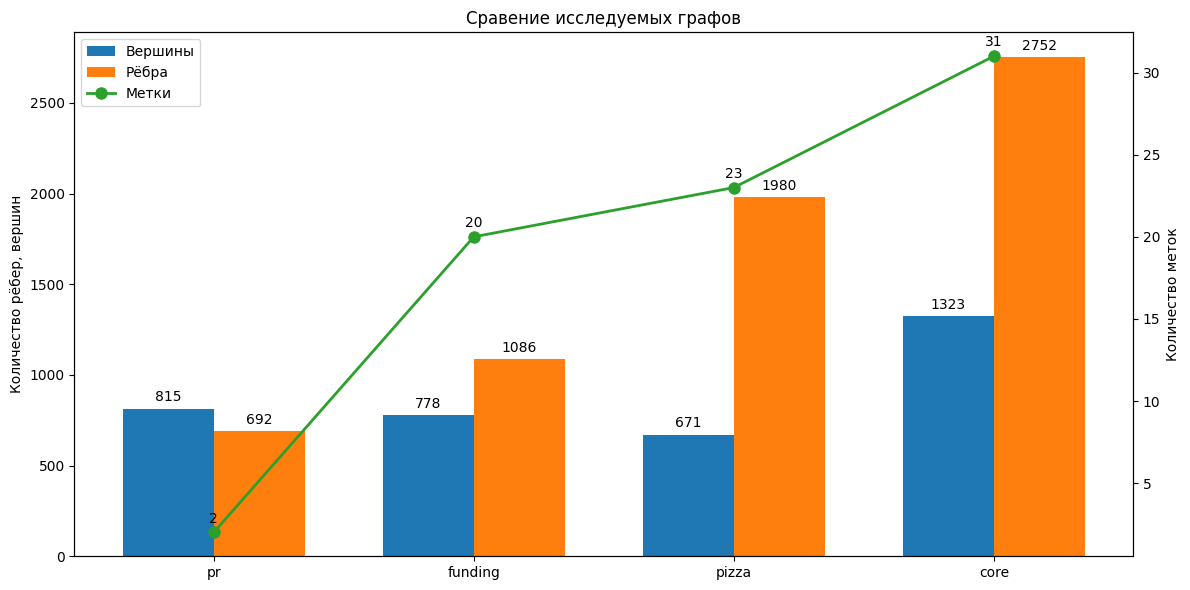

In [83]:
NUM_OF_EXPERIMENTS = 20
MATRICES = [csc_matrix, csr_matrix, dok_matrix, lil_matrix]
GRAPHS = ["funding", "pizza", "pr", "core"]
REGEX_PATTERNS = [
    "({l1} | {l2})* {l3}",
    "({l3} | {l4})+ {l1}*",
    "{l1} {l2} {l3} ({l4}|{l1})*",
    "{l1}* ({l2} | {l3})+ {l4}*",
]

logging.disable(logging.INFO)


def compare_matrix_types():
    graph_data_list = []
    for graph in GRAPHS:
        data = get_graph_data(graph)
        graph_data_list.append((graph, data))
    plot_graph_data(graph_data_list)


def plot_graph_data(graph_data_list):
    sorted_data = sorted(graph_data_list, key=lambda x: len(x[1].labels))

    names = [item[0] for item in sorted_data]
    graph_data = [item[1] for item in sorted_data]

    n = len(graph_data)

    node_counts = [gd.node_count for gd in graph_data]
    edge_counts = [gd.edge_count for gd in graph_data]
    label_counts = [len(gd.labels) for gd in graph_data]

    x = np.arange(n)
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(max(12, n * 2), 6))

    rects1 = ax1.bar(
        x - width / 2, node_counts, width, label="Вершины", color="#1f77b4"
    )
    rects2 = ax1.bar(x + width / 2, edge_counts, width, label="Рёбра", color="#ff7f0e")

    ax2 = ax1.twinx()

    ax2.plot(
        x,
        label_counts,
        label="Метки",
        color="#2ca02c",
        marker="o",
        linewidth=2,
        markersize=8,
    )

    ax1.set_ylabel("Количество рёбер, вершин")
    ax2.set_ylabel("Количество меток")
    ax1.set_title("Сравение исследуемых графов")
    ax1.set_xticks(x)
    ax1.set_xticklabels(names)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)

    for i, v in enumerate(label_counts):
        ax2.annotate(
            f"{v}",
            (x[i], v),
            xytext=(0, 5),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


compare_matrix_types()

## Сравнение матриц

В этом разделе будет продемонстрирована разница между разными реализациями разреженных матриц.

In [85]:
def generate_label_regexes(labels):
    extended_labels = labels * (4 // len(labels)) + labels[: 4 % len(labels)]
    l1, l2, l3, l4 = extended_labels[:4]
    regex_patterns = [
        pattern.format(l1=l1, l2=l2, l3=l3, l4=l4) for pattern in REGEX_PATTERNS
    ]

    return regex_patterns

In [88]:
def run_experiment(method, regex, graph, source_vertices, matrix_class=csr_matrix):
    times = []
    for _ in range(NUM_OF_EXPERIMENTS):
        start_time = time.time()
        method(regex, graph, source_vertices, {}, matrix_class)
        end_time = time.time()
        elapsed_time = end_time - start_time
        times.append(elapsed_time)
    return np.mean(times), np.std(times)


def run_rpq_tests(graph_name, method, start_percent=30):
    timing_results = {matrix.__name__: [] for matrix in MATRICES}
    error_results = {matrix.__name__: [] for matrix in MATRICES}

    graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
    source_vertices = cfpq_data.generate_multiple_source_percent(graph, 30, seed=42)
    regex_patterns = generate_label_regexes(cfpq_data.get_sorted_labels(graph))

    for matrix_class in MATRICES:
        for regex in regex_patterns:
            mean, std = run_experiment(
                method, regex, graph, source_vertices, matrix_class
            )
            timing_results[matrix_class.__name__].append(mean)
            error_results[matrix_class.__name__].append(std)

    return timing_results, error_results

In [ ]:
def plot_combined_results(graph_name, tensor_results, bfs_results):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    cleaned_regex_patterns = [
        regex.replace("{", "").replace("}", "") for regex in REGEX_PATTERNS
    ]
    width = 0.2
    x = np.arange(len(cleaned_regex_patterns))

    ax = axes[0]
    for i, matrix_class in enumerate(MATRICES):
        matrix_name = matrix_class.__name__
        ax.bar(
            x - width / 2 + i * width,
            tensor_results[graph_name]["timing"][matrix_name],
            width,
            yerr=tensor_results[graph_name]["error"][matrix_name],
            label=matrix_name,
            capsize=5,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(cleaned_regex_patterns)
    ax.set_xlabel("Регулярное выражение")
    ax.set_ylabel("Время (секунд)")
    ax.set_title(f"Метод Tensor на графе {graph_name}")
    ax.legend()

    ax = axes[1]
    for i, matrix_class in enumerate(MATRICES):
        matrix_name = matrix_class.__name__
        ax.bar(
            x - width / 2 + i * width,
            bfs_results[graph_name]["timing"][matrix_name],
            width,
            yerr=bfs_results[graph_name]["error"][matrix_name],
            label=matrix_name,
            capsize=5,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(cleaned_regex_patterns)
    ax.set_xlabel("Регулярное выражение")
    ax.set_ylabel("Время (секунд)")
    ax.set_title(f"Метод BFS на графе {graph_name}")
    ax.legend()

    plt.tight_layout()
    plt.show()

### 30 процентов вершин стартовые

In [89]:
tensor_results = {}
bfs_results = {}

for graph_name in GRAPHS:
    tensor_timing, tensor_error = run_rpq_tests(graph_name, tensor_based_rpq)
    tensor_results[graph_name] = {"timing": tensor_timing, "error": tensor_error}

    bfs_timing, bfs_error = run_rpq_tests(graph_name, ms_bfs_based_rpq)
    bfs_results[graph_name] = {"timing": bfs_timing, "error": bfs_error}

/home/ancavar/server/PySymGym/.env/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/ancavar/server/PySymGym/.env/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/ancavar/server/PySymGym/.env/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/ancavar/server/PySymGym/.env/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/hom

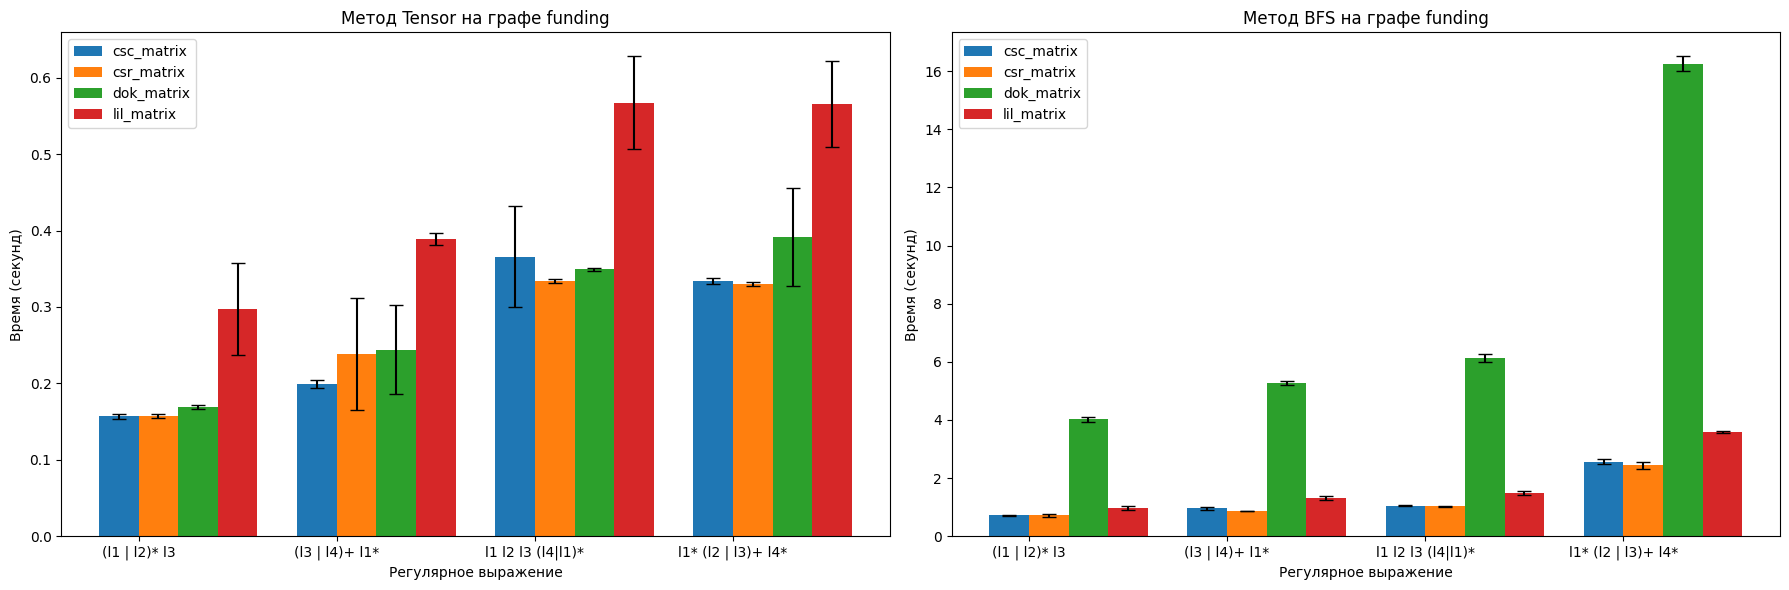

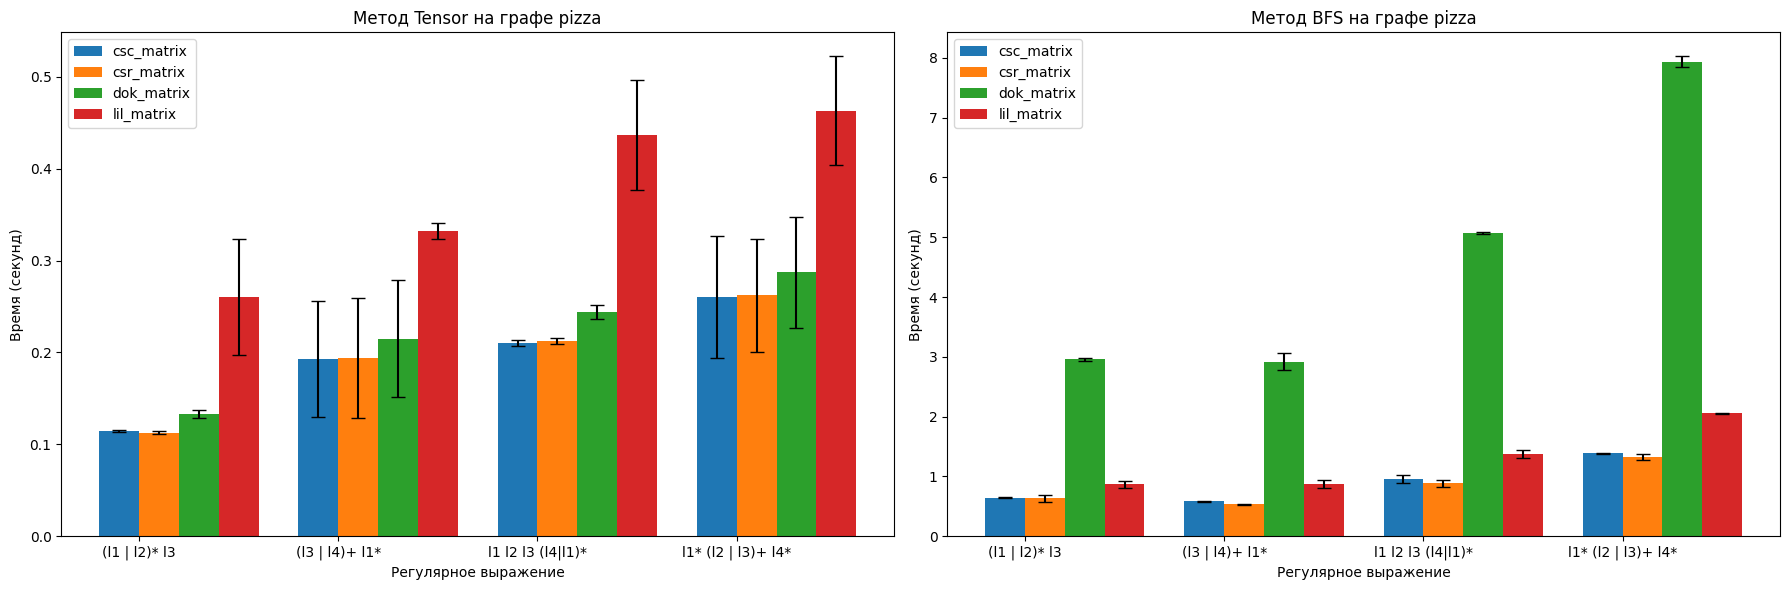

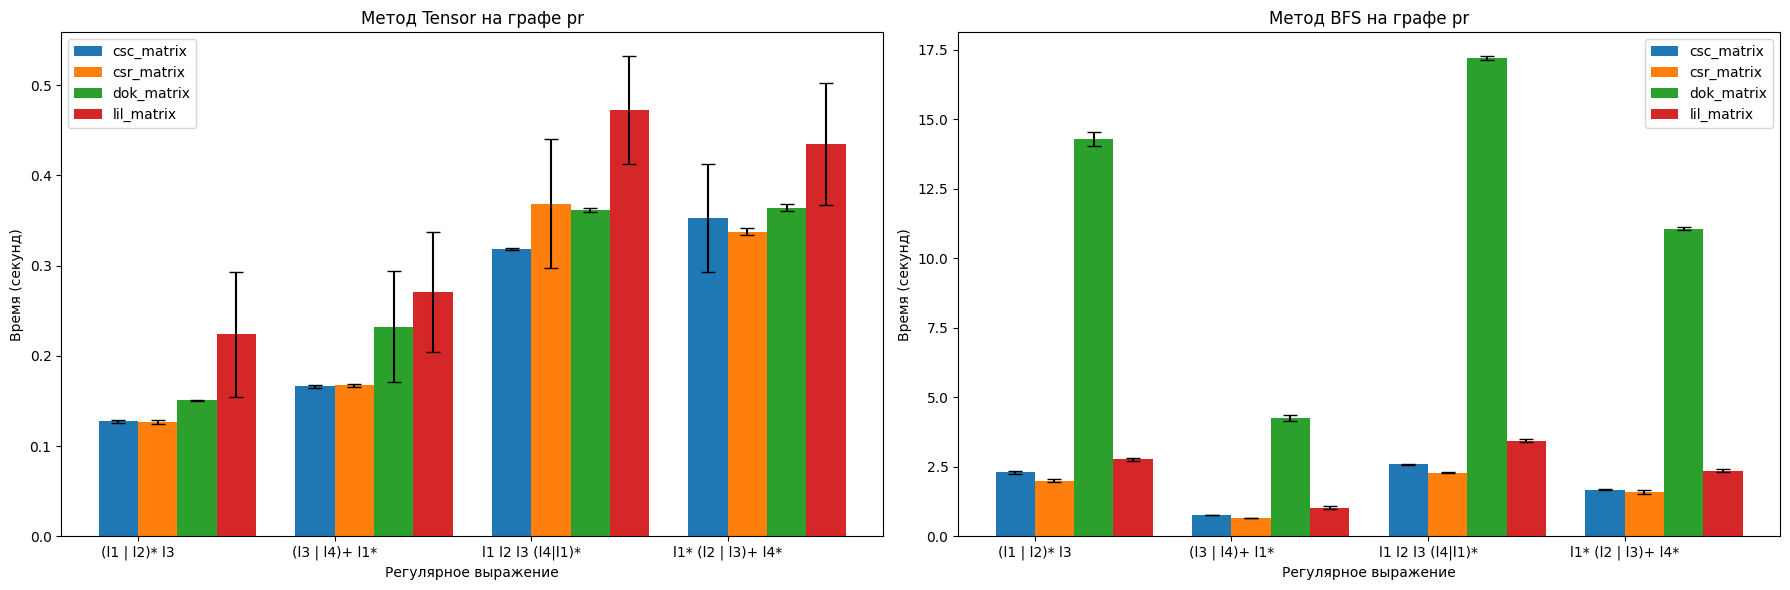

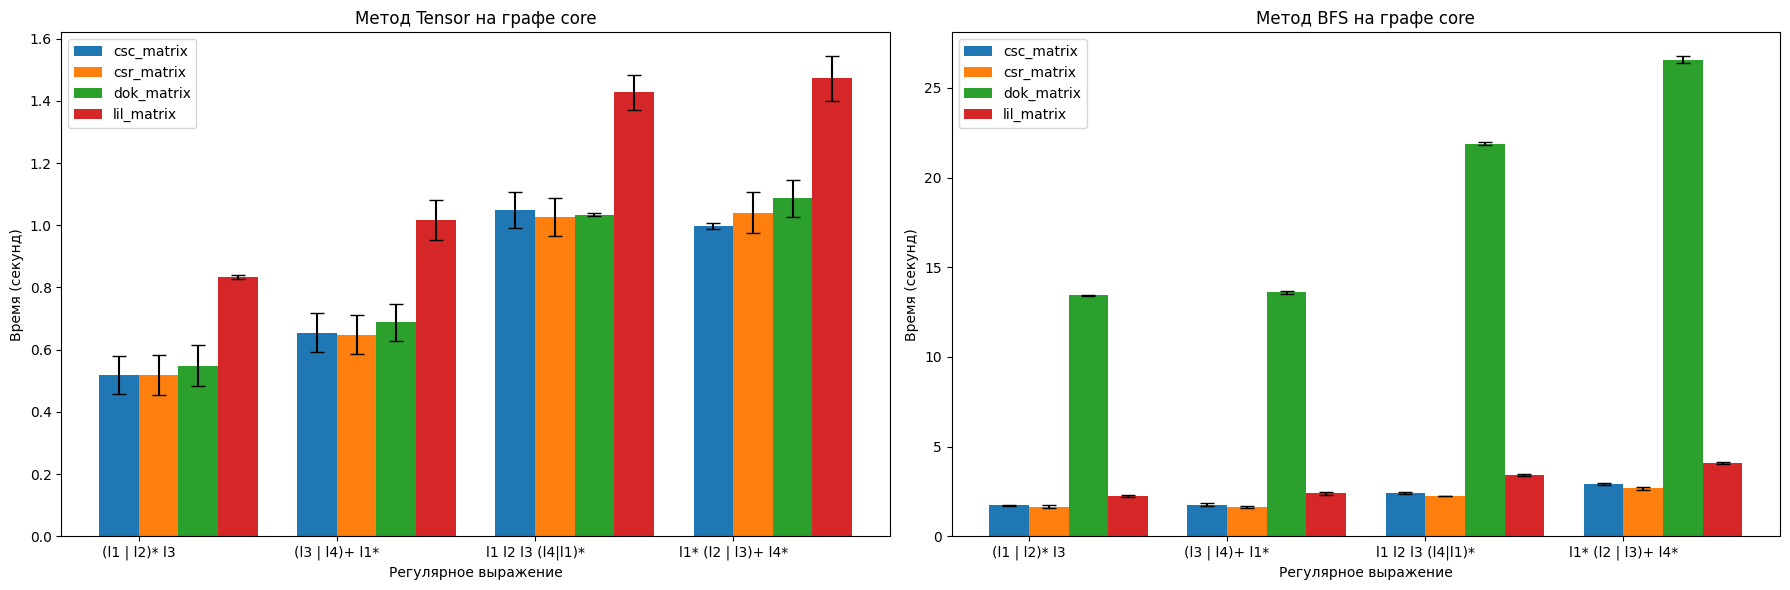

In [90]:
for graph_name in GRAPHS:
    plot_combined_results(graph_name, tensor_results, bfs_results)

Эксперименты с матрицами csr_matrix и csc_matrix в большинстве случаев ведут себя одинаково в обоих алгоритмах, с явным преимущество по скорости в тензорном произведении. dok_matrix является незначительно хуже csr_matrix и csc_matrix в тензорном произведении, однако этот тип матриц показал наихудший результат в алгоритме поиска в ширину, в некоторых случаях скорость выполнения которого достигала почти 30 секунд. Тип lil_matrix оказался хуже остальных в тензорном произведении и алгоритме поиска в ширину (за исключением dok_matrix). 

Полученные результаты можно объяснить реализацией двух алгоритмов, где инкрементальная "сборка" матриц, которая предполагается dok_matrix и lil_matrix, не требуется.

### 50 процентов вершин стартовые

In [ ]:
tensor_results = {}
bfs_results = {}

for graph_name in GRAPHS:
    tensor_timing, tensor_error = run_rpq_tests(graph_name, tensor_based_rpq, 50)
    tensor_results[graph_name] = {"timing": tensor_timing, "error": tensor_error}

    bfs_timing, bfs_error = run_rpq_tests(graph_name, ms_bfs_based_rpq, 50)
    bfs_results[graph_name] = {"timing": bfs_timing, "error": bfs_error}

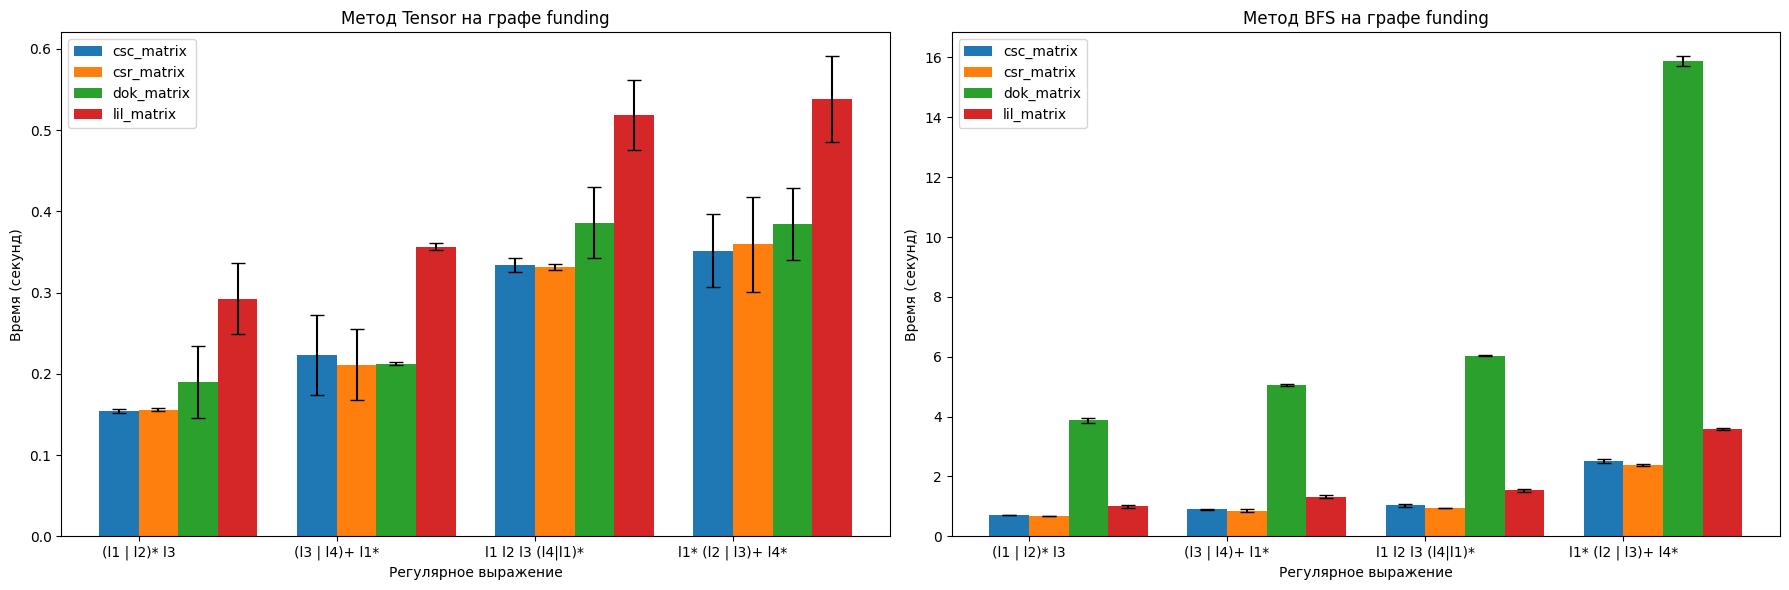

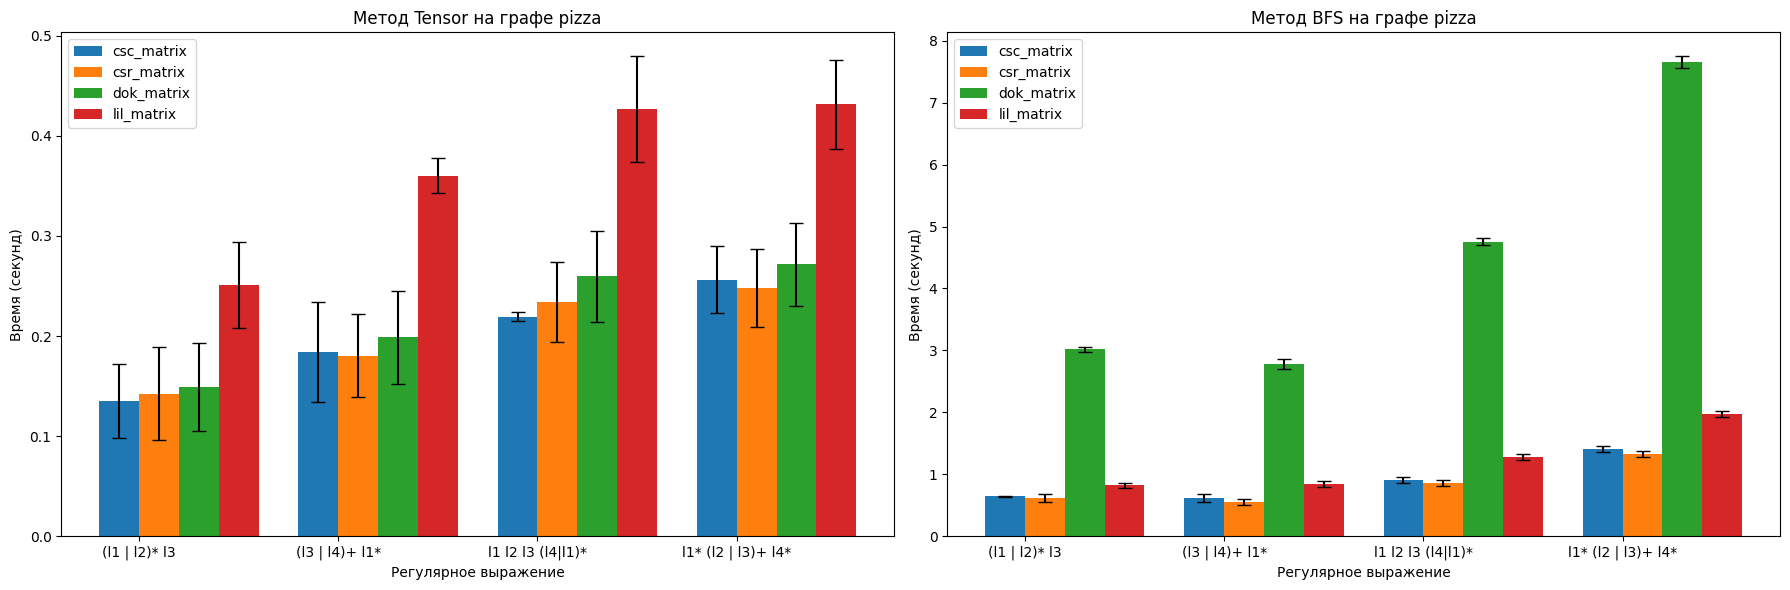

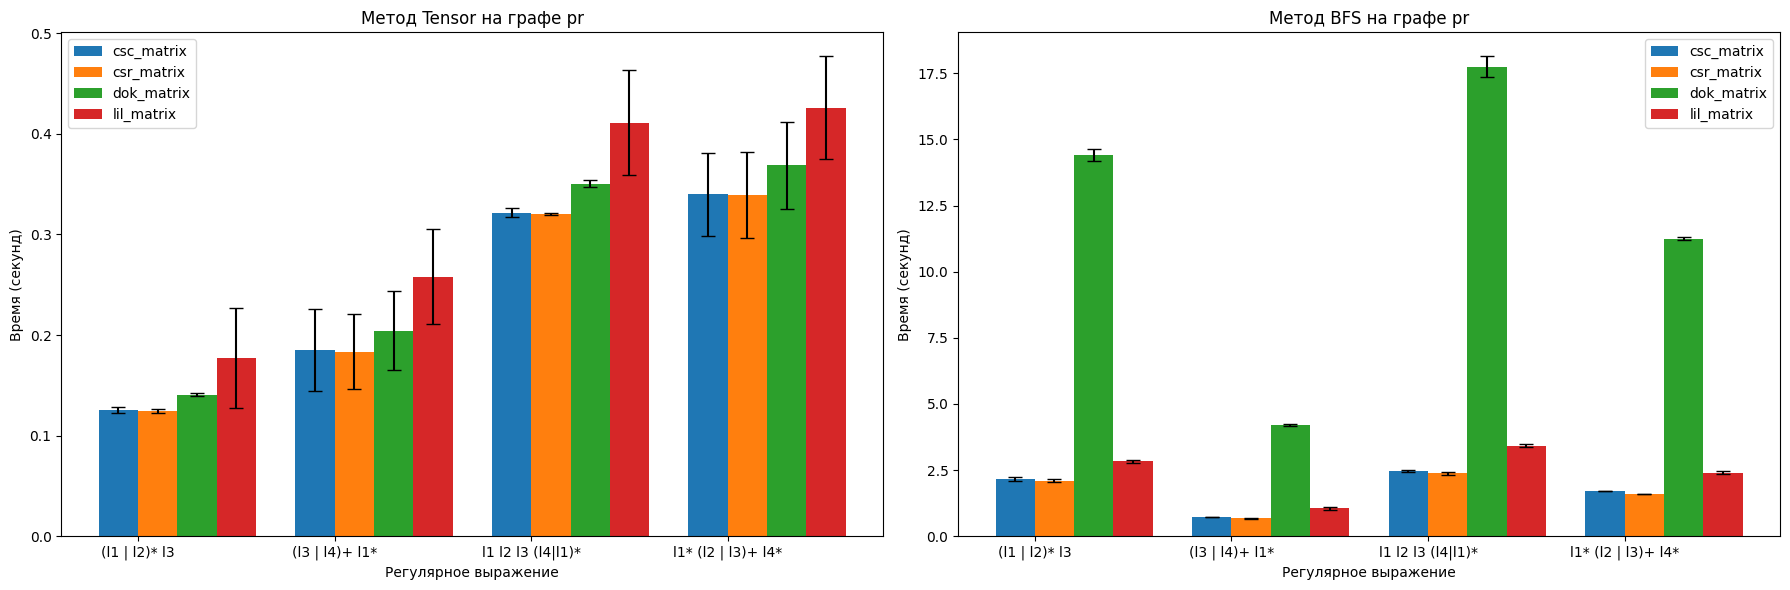

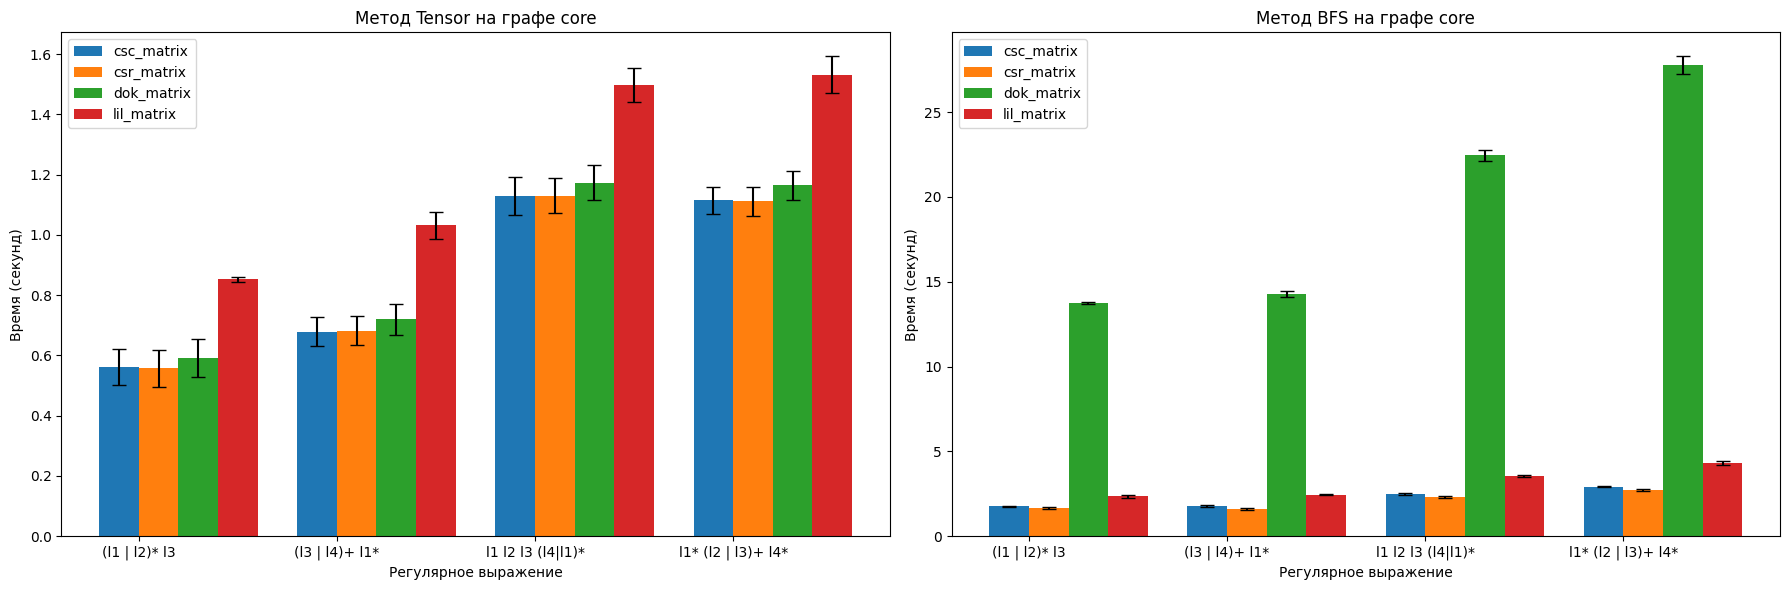

In [38]:
for graph_name in GRAPHS:
    plot_combined_results(graph_name, tensor_results, bfs_results)

Увелечение количество стартовых вершин с 30 до 50 процентов не привело к значительной разнице в полученных результатах.

## Сравнение размера стартового множества

В этом разделе будет продемонстрирована разница между двумя алгоритмами на разном размере стартового множества. Размер стартового множества определяеться процентом от общего числа вершин. Проценты, используемые в данной работе предоставлены в списке ```PERCENTAGE```. Разница алгоритмов будет изображена на графике в виде отношения времени работы тензорного произведения к алгоритму обхода в ширину.

In [80]:
PERCENTAGE = [2, 5, 13, 34, 55, 80, 100]


def run_rpq_tests(graph_name, method):
    graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
    regex_patterns = generate_label_regexes(cfpq_data.get_sorted_labels(graph))

    results = {}
    for start_percent in PERCENTAGE:
        source_vertices = cfpq_data.generate_multiple_source_percent(
            graph, start_percent, seed=42
        )
        timings = []

        for regex in regex_patterns:
            mean_time, _ = run_experiment(method, regex, graph, source_vertices)
            timings.append(mean_time)

        results[start_percent] = timings

    return results


def plot_start_percent(graph_name, tensor_results, bfs_results):
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    cleaned_regex_patterns = [
        regex.replace("{", "").replace("}", "") for regex in REGEX_PATTERNS
    ]

    ax = axes[0]
    for i, regex in enumerate(cleaned_regex_patterns):
        times_for_regex = [tensor_results[graph_name][p][i] for p in PERCENTAGE]
        ax.plot(PERCENTAGE, times_for_regex, label=regex)

    ax.set_xlabel("Процент начальных вершин (state percent)")
    ax.set_ylabel("Время (секунд)")
    ax.set_title(f"Метод Tensor на графе {graph_name}")
    ax.legend(loc="upper left")

    ax = axes[1]
    for i, regex in enumerate(cleaned_regex_patterns):
        times_for_regex = [bfs_results[graph_name][p][i] for p in PERCENTAGE]
        ax.plot(PERCENTAGE, times_for_regex, label=regex)

    ax.set_xlabel("Процент начальных вершин (state percent)")
    ax.set_ylabel("Время (секунд)")
    ax.set_title(f"Метод BFS на графе {graph_name}")
    ax.legend(loc="upper left")

    ax = axes[2]

    intersection_points = []
    for i, regex in enumerate(cleaned_regex_patterns):
        ratio_for_regex = [
            tensor_results[graph_name][p][i] / bfs_results[graph_name][p][i]
            if bfs_results[graph_name][p][i] > 0
            else 0
            for p in PERCENTAGE
        ]
        ax.plot(PERCENTAGE, ratio_for_regex, label=regex)

        for j in range(1, len(PERCENTAGE)):
            if ratio_for_regex[j - 1] > 1 and ratio_for_regex[j] < 1:
                x1, x2 = PERCENTAGE[j - 1], PERCENTAGE[j]
                y1, y2 = ratio_for_regex[j - 1], ratio_for_regex[j]
                intersection_x = x1 + (1 - y1) * (x2 - x1) / (y2 - y1)
                intersection_points.append(intersection_x)

    if intersection_points:
        mean_intersection_x = sum(intersection_points) / len(intersection_points)
        ax.scatter(mean_intersection_x, 1, color="red", zorder=5)
        ax.text(
            mean_intersection_x,
            1.05,
            f"{mean_intersection_x:.2f}",
            color="red",
            ha="center",
            va="bottom",
        )

    ax.set_xlabel("Процент начальных вершин (state percent)")
    ax.set_ylabel("Отношение времени (Tensor / BFS)")
    ax.set_title(f"Отношение Tensor/BFS на графе {graph_name}")
    ax.axhline(1, color="gray", linestyle="--")
    ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

In [ ]:
tensor_results = {}
bfs_results = {}

for graph_name in GRAPHS:
    for percentage in PERCENTAGE:
        tensor_results[graph_name] = run_rpq_tests(graph_name, tensor_based_rpq)
        bfs_results[graph_name] = run_rpq_tests(graph_name, ms_bfs_based_rpq)

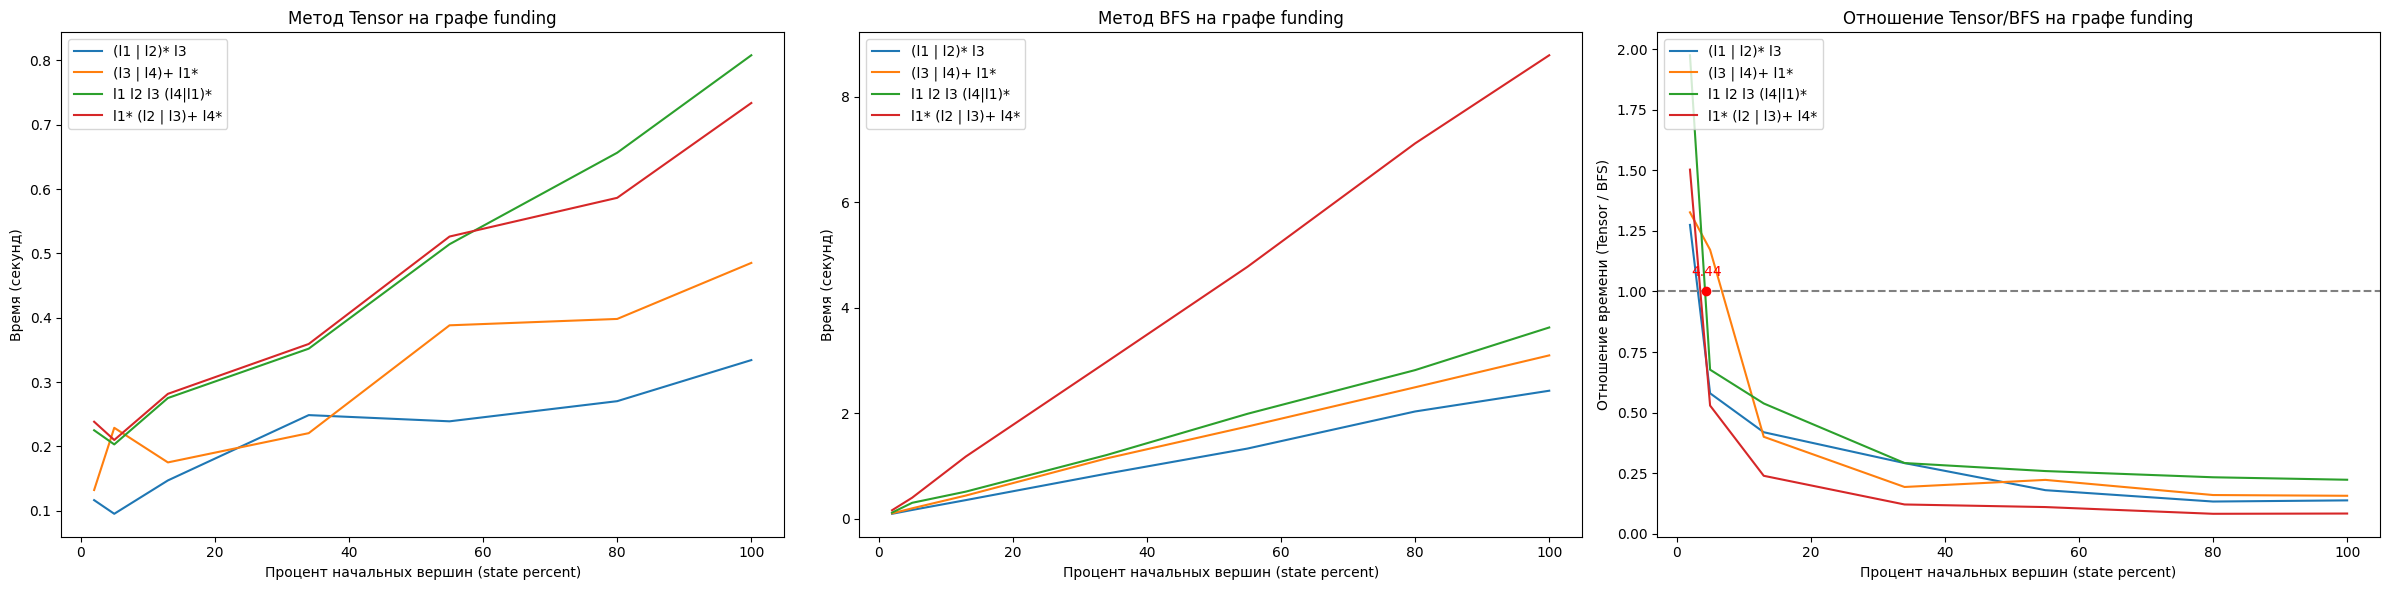

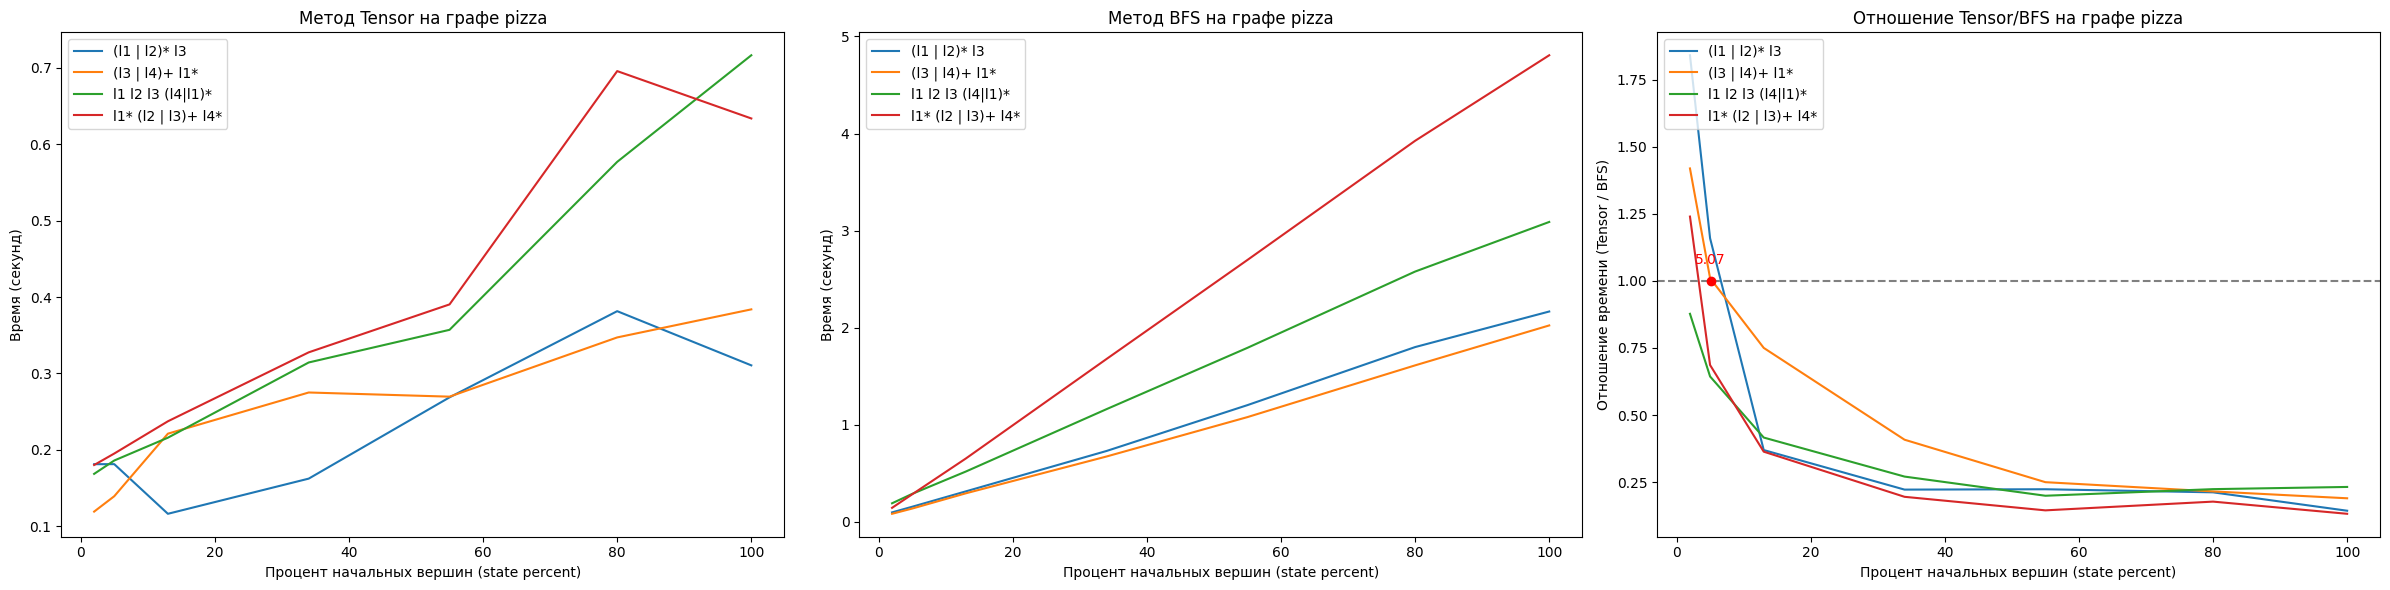

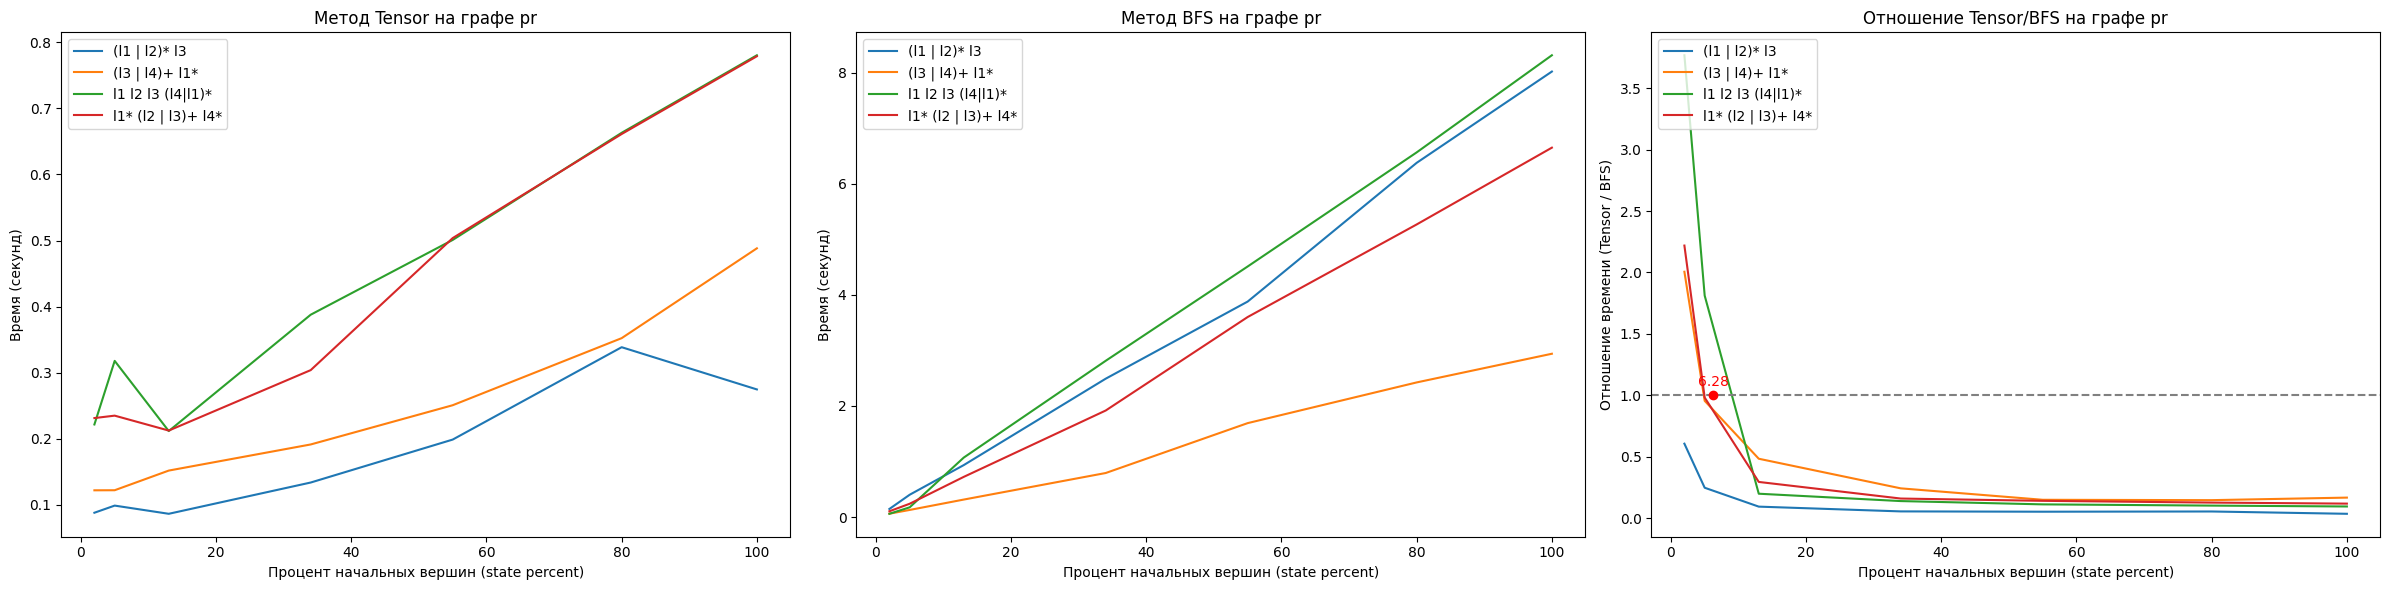

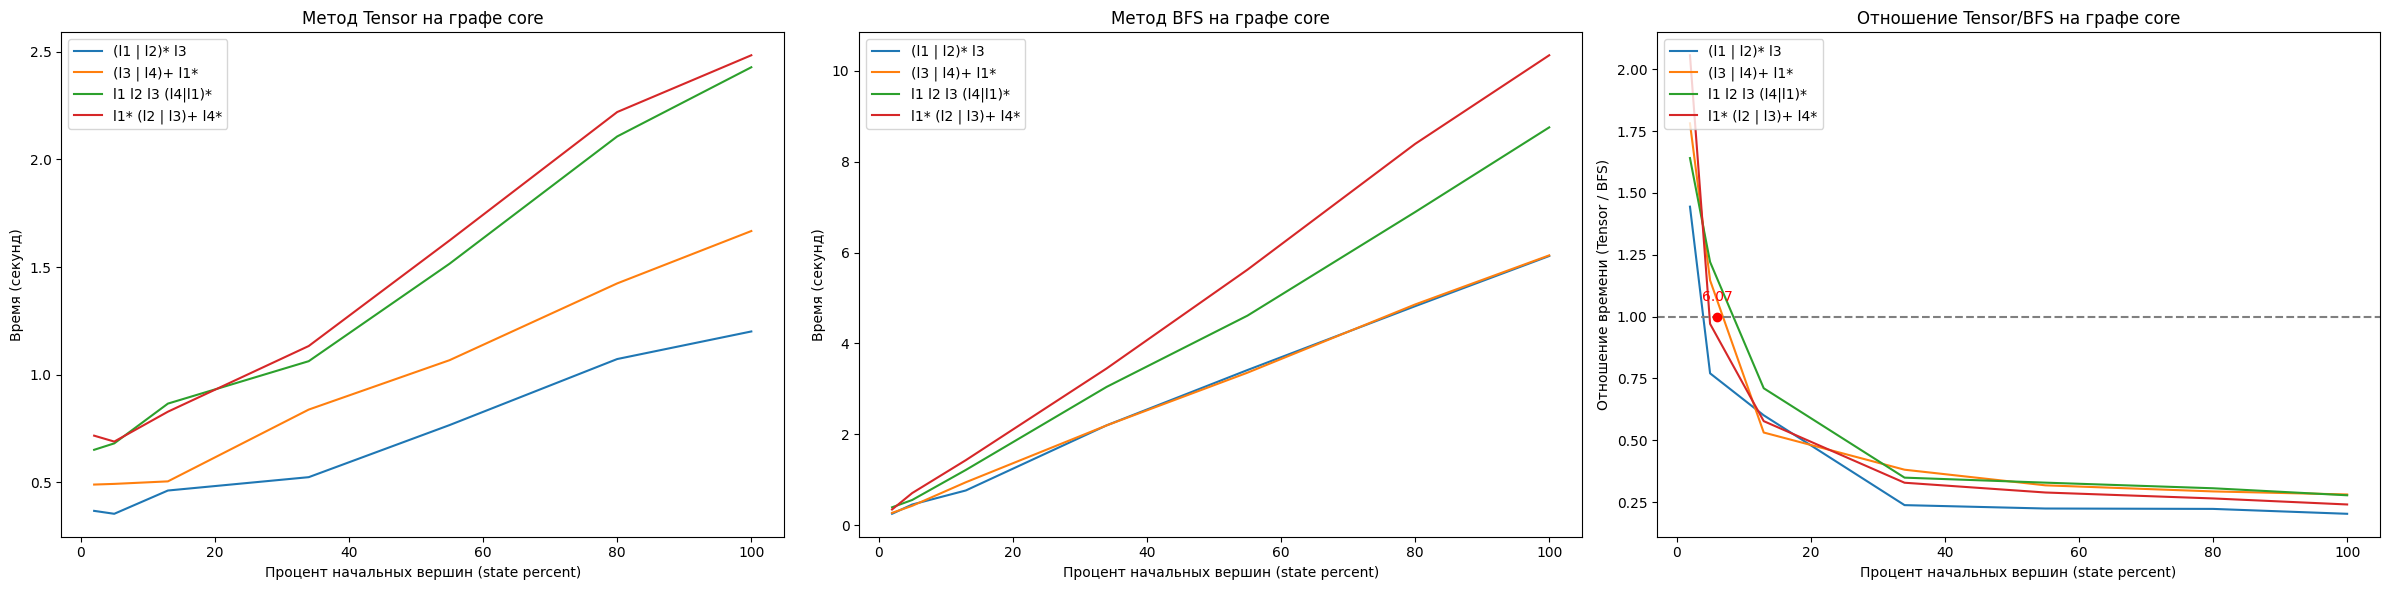

In [81]:
for graph_name in GRAPHS:
    plot_start_percent(graph_name, tensor_results, bfs_results)

Как можно заметить, с увеличением количества стартовых вершин становится разумнее использовать тензорное произведение. Однако, при очень маленьком проценте стартовых вершин выгоднее использовать алгоритм обхода в ширину. Так,
проинтерполировав получвшиеся ломанные, можем получить приблизительное количество стартовых вершин после которых тензорное произведение становится быстрее: $(4.44 + 5.07 + 6.28 + 6.07) / 4 = 5.465$.

Это неожиданный результат, так как вопрос, на который мы хотели ответить, стоял с точностью наоборот. Можно предположить, что "скорость сходимости" алгоритма тензорного произведения зависит от количества стартовых вершин, и чем больше, тем меньше произведений придется проделать.